# Some understanding of what networks learn


Idea : 
- Consider doing, a human vs vehicle binary image classification task. Would it not be amazing to have a learned representation that consists of a set of binary units. Binary units that glow to indicate presence of a feature. The set of these binary lights together will then identify the input. For face detector, these units could be a nose, 2 eyes, 2 ears, a mouth, and a couple of geometrical alignment scores. These would be awesome to have. I am not suggesting that we use a manual feature extractor.

![title](cyclops.jpg)

- I want my neural networks have some advantages from the manual feature engineering systems. There are many interpretations of this figure. This figure is very likely the original intuition behind neurons and neural networks. Obtain a decision tree style vector, decompose image into simple components (linear algebra). But I do think this figure is important in DL now more than ever. By having this amazing decision vector, image reasoning becomes trivial. We can compare 2 different human faces, we can deal with occlusion easily. Does a person have hair ? How many eyes does a person have ?


**Quick why**
- Any image understanding system should be able to do visual question answering on par with humans. It should be either explicit (rules or first order logic) or implicit (using another model with features fixed from the image understanding system). Explicit answering to visual question understanding systems is shown in the figure, implicit answering should work just fine. But I do think that in the near term, it will be hard to explicit image understanding

- While building models in industry or in academia or for a kaggle contest, I was focusing almost exlusively on a single metric, `Loss on validation set`. With too much focus on results (the how part), I have forgotten about what, where and why questions. I did not look at the data points where the network erred. I never bothered to check what the network learns, why it behaves the way it does. If you ask me why the network is making a specific prediction, I would not be able to answer. Most importantly, given a new image it would have been hard for me to guess the behaviour of the network. Say if I trained a face detector from a dataset and had a 95% accuracy score on validation set, I would have thought job done. 

- **I was blown away when a model gave 80% validation accuracy (on a binary classification task) despite using a wrong input transformer.**




1. **Can we build such a good feature representation system ?**
2. **Why do we check if the representation is learning anything useful ?**
3. **How do we check if the representation is learning anything useful ?**


These are the questions that I seek to answer in this post.






## Step 1 start : 

* Question - **Can we build such a good feature representation system ?**

    * Having a sparse layer with binary activation seems like a good first step. 
    * We can make a layer sparse by adding a L1 regularizer on the activation. 
    
    * Image : X, Target => y, Binarized sparse representation => g
    
    **Simple Model**
    
    \begin{align}
        h & = relu( W_1X + b_1) \\
        g & = max(W_2h + b_2, 0) \\
        p & = W_3x + b \\
        Loss & = CrossEntropy(p, y) + \lambda\sum|g| \\ \\ 
    \end{align}
    
    * Update weights using gradient descent
    
    **Conv net classifier**
    
    \begin{align}
        a & = Pool(Conv1(X)) \\
        b & = Pool(Conv2(a)) \\
        c & = Pool(Conv3(b)) \\
        d & = Relu(W_1c + b_1) \\
        e & = Relu(W_2d + b_2) \\
        g & = Relu(W_3d + b_3) \\
        p & = W_4g + b_4 \\
        Loss & = CrossEntropy(p, y) + \lambda\sum|g| \\ \\ 
    \end{align}
    
    

Let's do this using the amazing pytorch. 


## Step 1 break down:

    1.1. Load dataset and get loaders for train and test sets. 
    1.2. Write a simple classifier and check if forward propagation works for random input
    1.3. Train the network
    1.4. Evaluate the network


### Step 1.1 : Load dataset and get train, test dataloaders

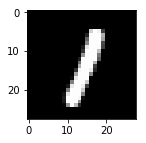

(<torch.utils.data.dataloader.DataLoader at 0x129df7c88>,
 <torch.utils.data.dataloader.DataLoader at 0x129e8fbe0>)

In [7]:
from collections import Counter
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torchvision import transforms
import torchvision.datasets as datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.1307,))
])

train_set = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./', train=False, download=True, transform=transform)

batch_size = 25

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

def display(image):
    plt.figure(figsize=(2,2))
    plt.imshow(image.reshape((28,28)), cmap = 'gray')
    plt.show()

for i, (inputs, outputs) in enumerate(train_loader):
    for image in inputs.numpy():
        display(image)
        break
    break
    
train_loader, test_loader

###  Step 1.2 : Classifier and forward prop check

In [19]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.fc1 = nn.Linear(64 * 9, 120)
        self.fc2 = nn.Linear(120,120)
        self.encoding = nn.Linear(120,25)
        self.fc3 = nn.Linear(25,10)
        
        
    def forward(self, x):
        x = x.reshape((x.shape[0],1,28,28))
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = torch.relu(self.encoding(x))
        
        return self.fc3(encoded), encoded
        

    
classifier = Classifier()
classifier(torch.randn((1,1,28,28)))[0].shape

torch.Size([1, 10])

### Step 1.3 : Train the network

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum = 0.9)

def fit(model, train_loader, metric, optimizer, epochs = 5, log_every = 100):
    for j in range(epochs):
        total = 0
        correct = 0
        losses = []
        for i, (inputs, outputs) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions, encoded = model(inputs)
            loss = metric(predictions, outputs)  
            loss += 0.0001 * torch.sum(torch.abs(encoded))
            correct += sum(torch.max(predictions, -1)[1] == outputs).item()
            total += predictions.shape[0]
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if i%log_every == 0:
                print(i, j, np.mean(losses), correct/total)
                
fit(classifier, train_loader, criterion, optimizer, epochs = 3, log_every = 1000)

0 0 2.315103530883789 0.08
1000 0 0.4738451243675017 0.8585014985014985
2000 0 0.3013646187635882 0.9157621189405297
0 1 0.06324967741966248 1.0
1000 1 0.08944524189719667 0.9820579420579421
2000 1 0.08264176792901257 0.9837481259370315
0 2 0.20773132145404816 0.96
1000 2 0.05944137936541727 0.9893706293706294
2000 2 0.06057554952472612 0.9886456771614193


### Step 1.4 : Evaluation

In [21]:
def evaluate(model, test_loader):
    correct = 0
    total = 0
    for i, data in enumerate(test_loader):
        inputs, outputs = data
        predictions, encoded = model(inputs)
        predictions = torch.max(predictions, -1)[1]
        correct += sum(predictions == outputs).item()
        total += predictions.shape[0]
    return correct / total
        
        
evaluate(classifier, test_loader)

0.9899

We have a decent image classifier that includes a sparse layer with 25 neurons.
## Step 1 end

## Step 2 start
* Question -  **Why do we check if the representation is learning anything useful ?**
* It took some time for me to get used to the idea of why should we check before how.

In my limited experience with supervised Deep Learning(DL), I often felt that I had absolutely no idea why the models behaved the way it did. If I had to build a text classification system that detected graded sentiment of the user. Given a labelled dataset of sentences and graded sentiment scores, no matter how subjective the gradations are, you can build a deep learning based that does reasonably well (accuracy above 80 or 90) using state of the art embeddings. I see people saying things like if you want to detect sarcasm, you just need a labelled dataset. To me this represents a problem of abusing the ability to learn representations. My claim is that if we impose the correct set of learning constraints, neural networks would become more interpretabble. If I made a typo or or added arbitary combination of words, the class would change. Accuracy on test set is not everything. It is not hard to build a DL model that gives a good accuracy on your test dataset. 


**None of the above input** - **What is a mnist classifier supposed to do when it fed is an image from Rick and Morty ?** A human can easily say that's `none of the above`. There can be no practical image classification without being able to handle `none of the above input`. People I have talked to in industry do have good heuristics/models to deal with `None of the above` input. I suspect that using `none of the above` examples to train will solve some of the other problems that arise because of dl. Using adverserial examples in training makes model robust to adversarial attacks, ( I view this as a subcase of using a specific subset of `none of the examples` to train). I think that DL has reached the point where we have to start thinking about clear methodologies to sample (most helpful) `none of the above` examples from the large space of all possible images. 

Accuracy score on your test set is not generalization accuracy. The number of possible 28*28 grayscale images on a 0-1 scale, if we have round of all pixel values to 4 decimals, it is 28 * 28 * 10000 = 78 million images. Unless we test on a dataset whose test size is comparable to this 78 million, (say 10 million examples) I would be very suspsicious of the model's behaviour. Number of images in sample space increases exponentially with number of digits allowed. Such an expensive and exhaustive test can avoided if were to develop reliable models that can be attributable. 

Networks are easily subject to attacks. It is possible to add some amount of noise to change target class.

* Step 2.1 **Untargetted attacks**
    * [Fast signed gradient method](https://arxiv.org/pdf/1412.6572.pdf)
    * In a neural network, input is also differentiable. 
    * Going in direction of positive gradient increases loss. 
    * Do gradient ascent to update input while constraining image to look like original results in a new image that looks indistinguishable to human but might belong to a different class with respect to the model.
    * To move step size control to a hyper parameter, we fix gradient magnitude to 1 by using the sign function.
    \begin{align}
        p &= Classifer(X) \\
        Loss & = - CrossEntropy(p, y) \\
        X &= X - |\frac{\partial Loss}{\partial Image}| \\
        X &= Clamp(0,1) \\
    \end{align}
    
    * Image - X, correct target - y
    
   



### Step 2.1 Untargetted FSGM

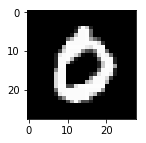

tensor(0)


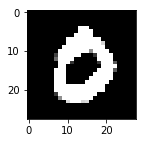

tensor(8)










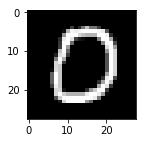

tensor(0)


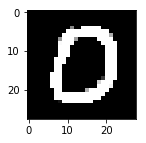

tensor(8)










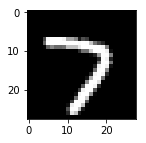

tensor(7)


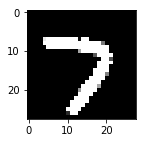

tensor(3)










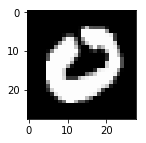

tensor(0)


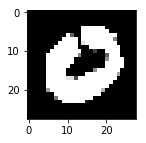

tensor(8)










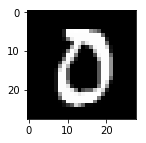

tensor(0)


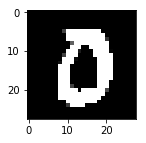

tensor(8)










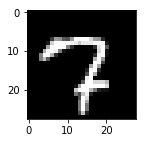

tensor(7)


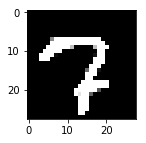

tensor(2)










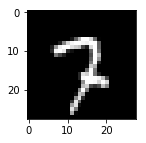

tensor(7)


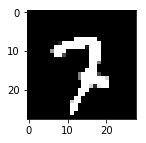

tensor(2)










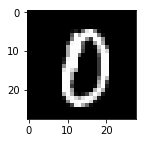

tensor(0)


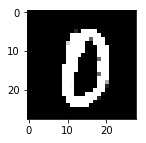

tensor(8)










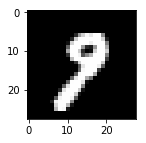

tensor(9)


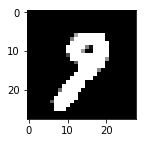

tensor(8)










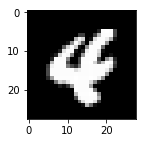

tensor(4)


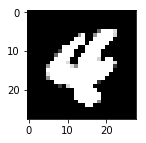

tensor(8)










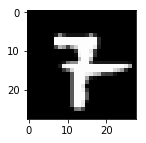

tensor(7)


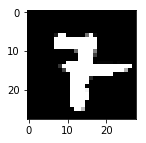

tensor(2)




num attacked 11


In [22]:
def predict_probs(image, classfier):
    return classifier(image.reshape((1,1,28,28)))[0]
    
def predict(image, classifier):
    return predict_probs(image, classifier)[0].argmax()


def do_untargetted_attack(image, classifier):
    adv_image = image + 0.3 * torch.sign(image.grad.data)
    return torch.clamp(adv_image, 0, 1)
    
mistakes = 0
metric = nn.CrossEntropyLoss()
for inputs, outputs in test_loader:
    for image, target in zip(inputs, outputs):
        image.requires_grad = True
        classifier.zero_grad()
        predictions = predict_probs(image, classifier)
        prediction = predict(image, classifier)
        loss = metric(predictions, target.reshape(1,))
        loss.backward()
        
        adv_image = do_untargetted_attack(image, classifier)
        new_prediction = predict(adv_image, classifier)
        
        is_prediction_correct = (prediction == target).item()
        is_attack_success = (prediction != new_prediction).item()
        
        if is_prediction_correct and is_attack_success:
            print('\n\n\n')
            mistakes += 1
            display(image.data)
            print(prediction)
            display(adv_image.data)
            print(new_prediction)
            print('\n\n\n')
    if mistakes > 10:
        break

print('num attacked', mistakes)

### Step 2.2 Lame targetted attack

 * I am doing the lamest thing you can try.
 * Slight tweak, we try to match image to a specific target category y'
    
    
       
\begin{align}
    p &= Classifer(X) \\
    Loss & = - CrossEntropy(p, y') \\
    X &= X - \lambda |\frac{\partial Loss}{\partial Image}| \\
    X &= Clamp(0,1) \\
\end{align}
    
 * Image - X, Incorrect target - y'
 * Should be harder to do. From my experiments only very few cases can attacked in a targetted manner and still look like the original image



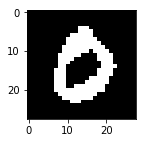

original_target tensor(0)
original_prediction tensor(0)
adversarial_prediction tensor(8)


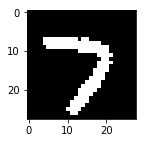

original_target tensor(7)
original_prediction tensor(7)
adversarial_prediction tensor(3)
done


In [26]:
metric = nn.CrossEntropyLoss()
adv_target = torch.tensor(1, dtype = torch.long)
adv_target = adv_target.reshape((1,))
lr = 0.1
adv_target = torch.tensor(0, dtype = torch.long)
adv_target = adv_target.reshape((1,))
for inputs, outputs in test_loader:
    for image, target in zip(inputs, outputs):
        original_image = image
        image.requires_grad = True 
        prediction = predict(image, classifier)
        for i in range(20):
            adv_predictions = predict_probs(image, classifier)
            loss = metric(adv_predictions, adv_target)
            loss.backward()
            with torch.no_grad():
                image -= lr * image.grad
                image.data = (image.data - image.data.mean()) / (image.data.std() + 0.00001)
                image.data = torch.clamp(image.data, 0, 1)
        adv_prediction = predict(image, classifier)
        if (target == prediction).item() and (prediction != adv_prediction).item():
            display(image.data)
            print('original_target', target)
            print('original_prediction', prediction)
            print('adversarial_prediction',  adv_prediction)
        
        
    break

#### Why Summary 

* Models are prone to simple attacks. 
* We cannot reliably guess the predictions of our models. 
* Models do not know how to deal with `none of the above` input.
* Sample space of all possible images is so large that it is very hard to assess generalization accuracy. 


By making models learn features, we don't explictly understand what the features are. The model does not state why it behaves the way it does and we do not understand why. The HOW of supervised learning has reached the point where the next wave of progress is going to come from asking WHAT and WHY (blasphemious futurology without any research). We have pushed the burden of feature discovery onto the models, so it is only our responsibility to find out what those features are, what makes the model fire. Philosophical responsiblities aside, we cannot build machine learning products which are of significant impact unless we completely understand `where`, `what` and `why`.


We need to build reliable models.

Understanding what models learn is the first step towards reliability

## Step 2 ends here


## Step 3 begins here


This step focuses on visualizing what the networks learn. 
I want to understand what they learn and regions in input that get recognized

### Step 3.1 Heatmaps

* I wanted to answer the `where question`. Which regions in the input image make the neuron fire. 
* The easiest solution that I saw in [visualizing CNN](http://cs231n.github.io/understanding-cnn/) was generating activation heatmap through occlusion.
* Hide a small part of input image with a patch. Make all positions within the patch 0 and find probability of new image.
* Slide patch across the image and repeat procedure.
* Give a impact score proportional to loss in probability score after patch application. 
* There is high probability loss in important areas. 
* The 2d grid of impact scores is the activation heatmap.


ACTIVATION IMAGES AND HEATMAPS


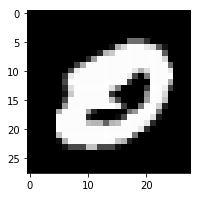

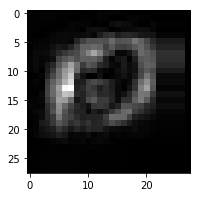

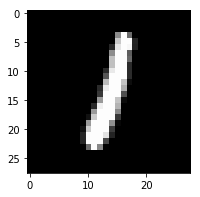

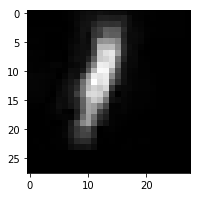

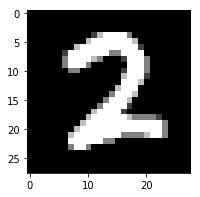

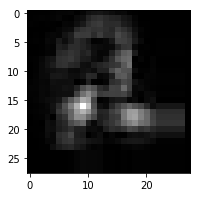

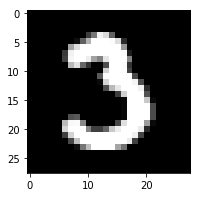

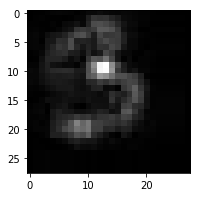

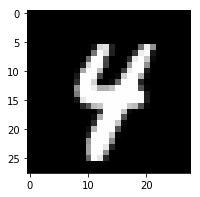

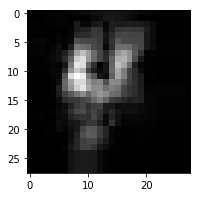

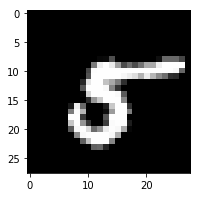

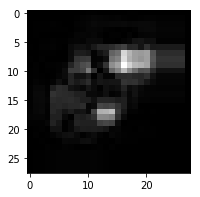

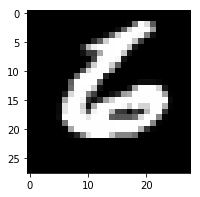

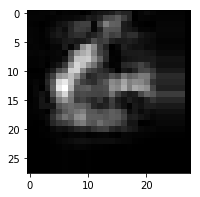

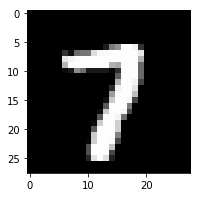

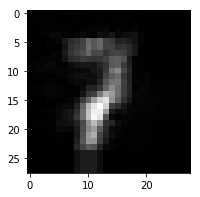

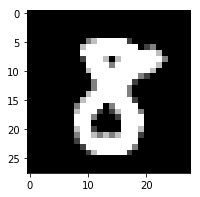

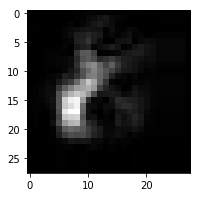

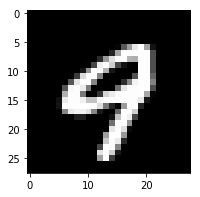

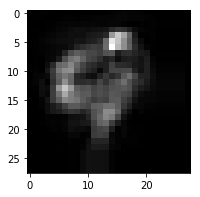

In [52]:
# Find what part of image contributes to probability score by occluding image
from collections import defaultdict

def get_activation_heatmap(digit, test_loader):
    digit_images = None
    d = defaultdict(lambda : 0)
    for inputs, outputs in test_loader:
        for image, output in zip(inputs, outputs):
            if output.item() == digit:
                digit_image = image
    
   
    heat_map = np.zeros((28,28))
    

    digit_image = digit_image.reshape((28,28,1))
    actual_predictions, actual_encoded = classifier(digit_image.reshape((1,28,28,1)))
    

    for i in range(25):
        for j in range(23):
            occluded_image = digit_image.numpy().copy()
            occluded_image[i:i+5,j:j+5] = 0
            occluded_predictions, occluded_encoded = classifier(torch.tensor(occluded_image.reshape((1,28,28,1))))
            difference = 255 * abs(actual_predictions[0][digit].item() - occluded_predictions[0][digit].item())
            heat_map[i:i+5,j:j+5] = difference
        
    
    
    plt.figure(figsize=(3,3))
    plt.imshow(digit_image.reshape((28,28)), cmap = 'gray')
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(heat_map, cmap = 'gray')
    plt.show()
        
       

            
print('ACTIVATION IMAGES AND HEATMAPS')      

for digit in range(10):
    get_activation_heatmap(digit, test_loader) 

There is a fairly obvious correspondence of heatmap with the input digit. Heatmaps are centered and roughly resemble the shape of most digits. Our conv nets do learn where the input is in the given image. Also there is small empirical evidence supporting "localization is a natural effect of classification"

### Step 3.2 - Draw most confident image

* I wanted to find out the most confident image a network draws given a class. 
* The idea is similar to FSGM, instead of going in the direction of gradient, we go towards direction of negative gradient.
    \begin{align}
        p &= Classifer(X) \\
        Loss & = CrossEntropy(p, y) \\
        X &= X - \frac{\partial Loss}{\partial Image} \\
    \end{align}
* Image - X, correct target - y
* **Gradient descent over input with the objective to increase original class probability**
* One way of generating image given a class. More deeper take at [Invertible CNN](https://arxiv.org/pdf/1705.08664.pdf)


0 0.635208010673523 tensor(-0.6352, requires_grad=True)
5000 -355.8967590332031 tensor(355.8968, requires_grad=True)


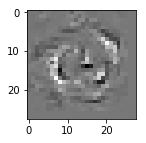

prediction vector tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward>) 



0 -0.26884981989860535 tensor(0.2688, requires_grad=True)
5000 -505.1878356933594 tensor(505.1878, requires_grad=True)


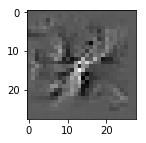

prediction vector tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward>) 



0 -0.4462510347366333 tensor(0.4463, requires_grad=True)
5000 -1057.9234619140625 tensor(1057.9235, requires_grad=True)


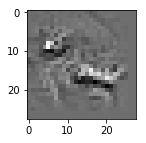

prediction vector tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward>) 



0 -0.9921870231628418 tensor(0.9922, requires_grad=True)
5000 -1563.3260498046875 tensor(1563.3260, requires_grad=True)


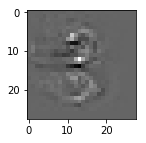

prediction vector tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward>) 



0 0.4298287034034729 tensor(-0.4298, requires_grad=True)
5000 -1045.4327392578125 tensor(1045.4327, requires_grad=True)


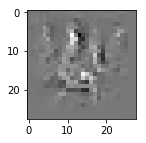

prediction vector tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward>) 



0 -0.484689861536026 tensor(0.4847, requires_grad=True)
5000 -679.8009033203125 tensor(679.8009, requires_grad=True)


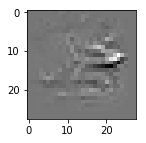

prediction vector tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], grad_fn=<SoftmaxBackward>) 



0 0.6982725858688354 tensor(-0.6983, requires_grad=True)
5000 -1829.7530517578125 tensor(1829.7531, requires_grad=True)


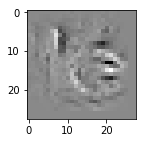

prediction vector tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], grad_fn=<SoftmaxBackward>) 



0 0.21568113565444946 tensor(-0.2157, requires_grad=True)
5000 -1064.868408203125 tensor(1064.8684, requires_grad=True)


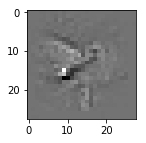

prediction vector tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], grad_fn=<SoftmaxBackward>) 



0 -0.6706562638282776 tensor(0.6707, requires_grad=True)
5000 -743.4417724609375 tensor(743.4418, requires_grad=True)


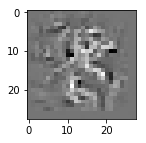

prediction vector tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], grad_fn=<SoftmaxBackward>) 



0 0.12110462039709091 tensor(-0.1211, requires_grad=True)
5000 -1192.48095703125 tensor(1192.4810, requires_grad=True)


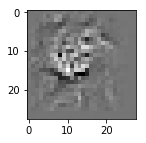

prediction vector tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], grad_fn=<SoftmaxBackward>) 





In [37]:

def generate_most_confident_image(digit):
    x = torch.randn((1,1,28,28), requires_grad = True)
    lr = 1
    for i in range(10000):
        predictions, encoded = classifier(x)
        loss = -predictions[0][digit]
        loss.backward()
        with torch.no_grad():
            x -= lr * x.grad
            x.grad.zero_()
            if i % 5000 == 0:
                print(i, loss.item(), predictions[0][digit])

    x = x.detach().numpy()
    x = x.reshape((28,28))
    plt.figure(figsize=(2,2))
    plt.imshow(x, cmap = 'gray')
    plt.show()

    return torch.softmax(classifier(torch.tensor(x).reshape(1,1,28,28))[0][0], dim = 0)

for i in range(10):
    print('prediction vector', generate_most_confident_image(i),'\n\n\n')

* There are some structural similarities with the original digits. Seems most clear with 5, 3. If you zoom out or go back from your screen, it becomes very clear. Also it looks like the aggregate image obtained by overlaying all input images.
* It is sad and not surprising that our network is learning most well to weird looking input images. If you ask a human to draw a 0, it would probably not look like the ones that have been generated.
* In fairness, there is a poor generation method and GANs do very well at generation. However, this is a structural weakness for the classifiers. They seem to respond to high dimensional noise images.

### Step 3.3 Which sparse neurons get activated

We finally revisit our amazing cyclops illustration. 

activating neurons for digit  0


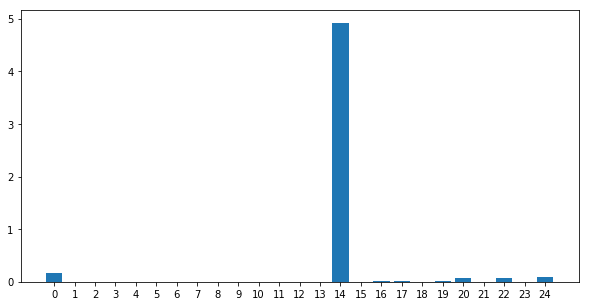

activating neurons for digit  1


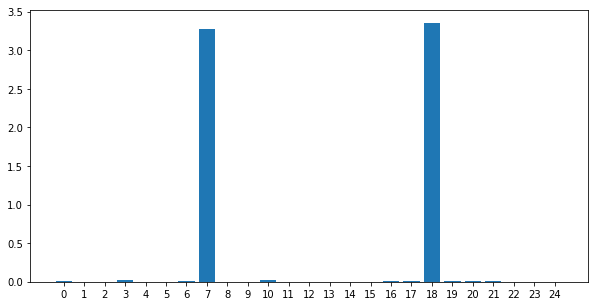

activating neurons for digit  2


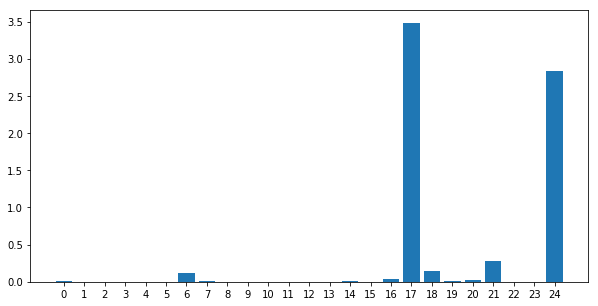

activating neurons for digit  3


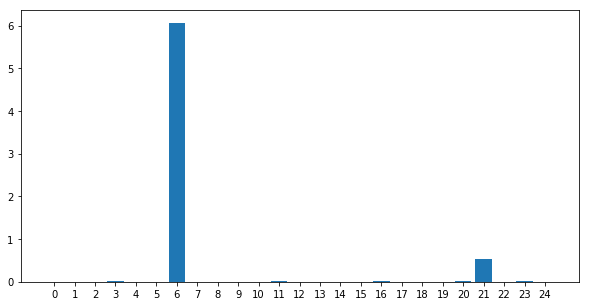

activating neurons for digit  4


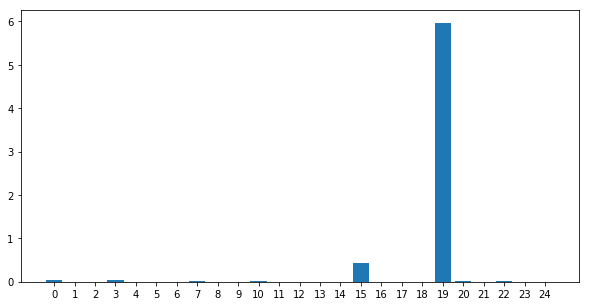

activating neurons for digit  5


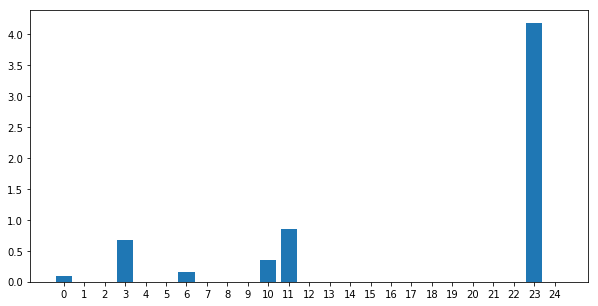

activating neurons for digit  6


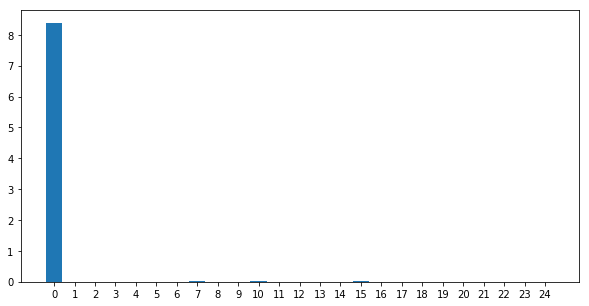

activating neurons for digit  7


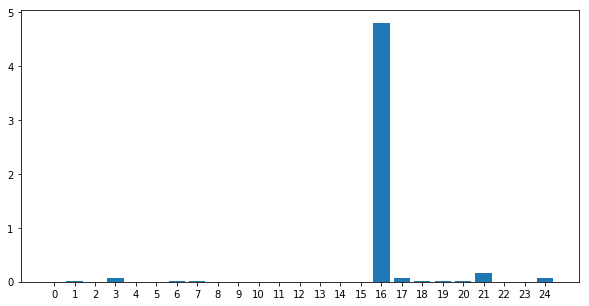

activating neurons for digit  8


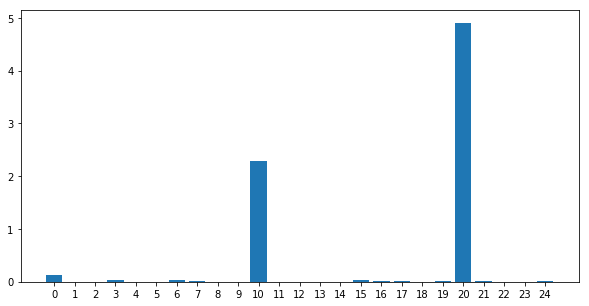

activating neurons for digit  9


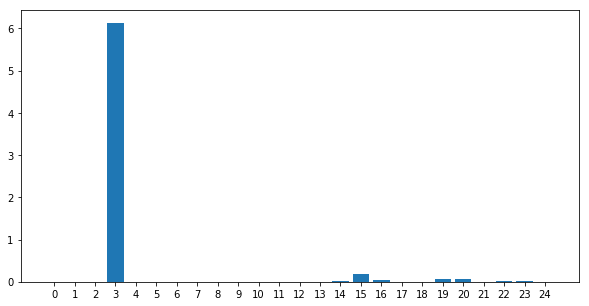

In [38]:
# find which neurons get activated for a given digit
from collections import defaultdict


def get_activating_neurons(digit, test_loader):
    d = defaultdict(list)
    for inputs, outputs in test_loader:
        predictions, encoded = classifier(inputs)
        for output, rep in zip(outputs, encoded):
            d[output.item()].append(rep.detach().numpy())
    d[digit] = np.array(d[digit])
    d[digit] = np.mean(d[digit], axis = 0)
    plt.figure(figsize=(10,5))
    plt.bar(range(0,25), d[digit])
    plt.xticks(range(0,25))
    plt.show()
        

for i in range(0,10):
    print('activating neurons for digit ', i)
    get_activating_neurons(i, test_loader)

Not bad. We have decomposed an image into a 25 long sparse vector. Each unit either fires or not fires. Number of activations for each digit are minimal and may be a bit too minimal. Now let us intepret what these neurons respond to.

### Step 3.4 find digits which activate a neuron

* For each neuron, group activations according to digit and generate a barchart

digit activation graph of neuron 0


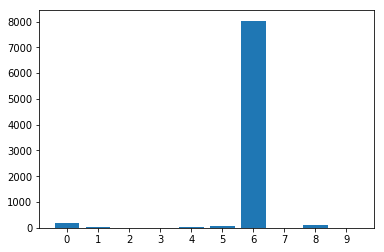

digit activation graph of neuron 1


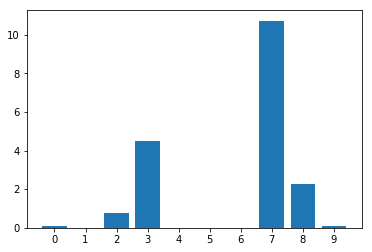

digit activation graph of neuron 2


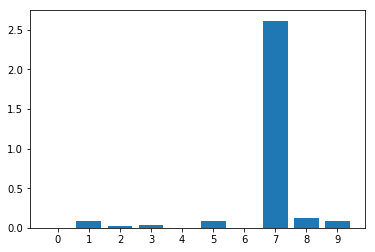

digit activation graph of neuron 3


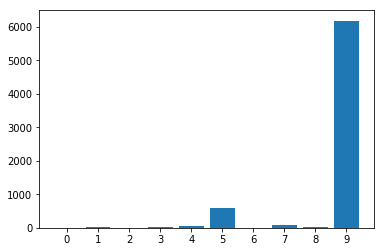

digit activation graph of neuron 4


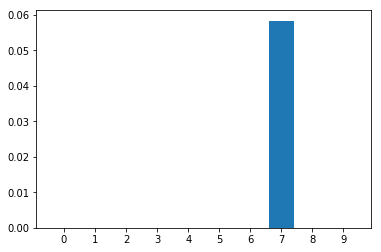

digit activation graph of neuron 5


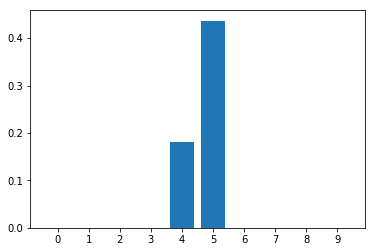

digit activation graph of neuron 6


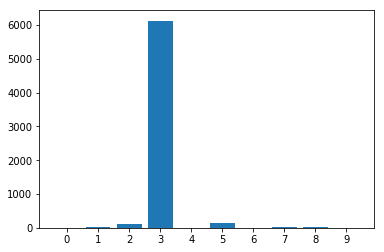

digit activation graph of neuron 7


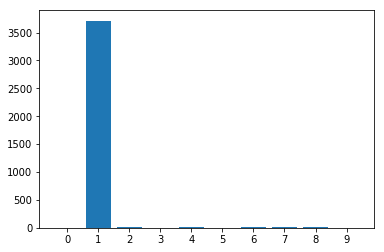

digit activation graph of neuron 8


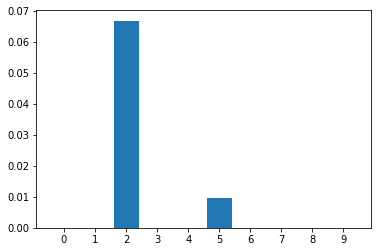

digit activation graph of neuron 9


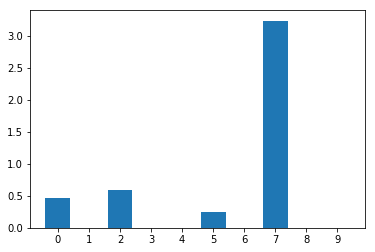

digit activation graph of neuron 10


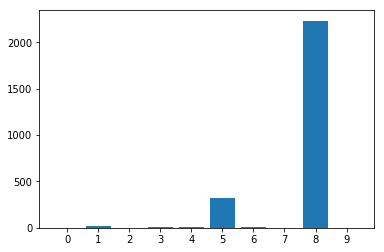

digit activation graph of neuron 11


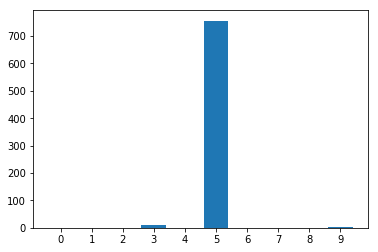

digit activation graph of neuron 12


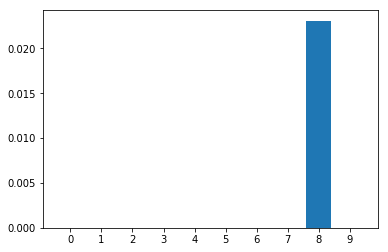

digit activation graph of neuron 13


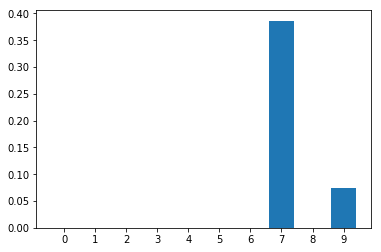

digit activation graph of neuron 14


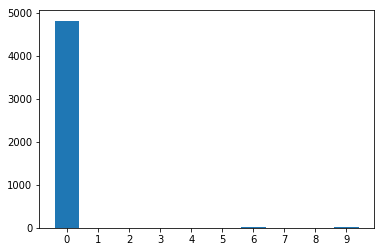

digit activation graph of neuron 15


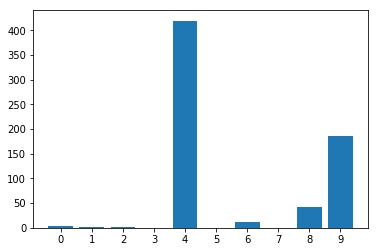

digit activation graph of neuron 16


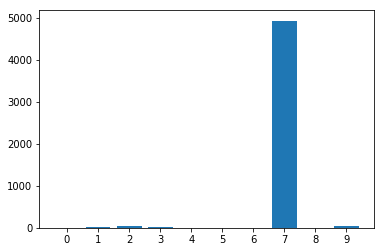

digit activation graph of neuron 17


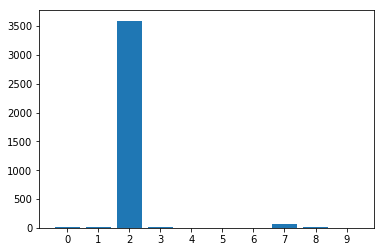

digit activation graph of neuron 18


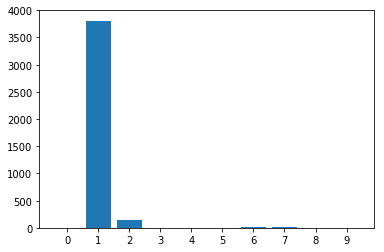

digit activation graph of neuron 19


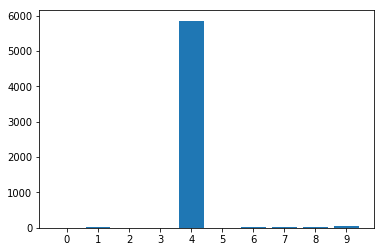

digit activation graph of neuron 20


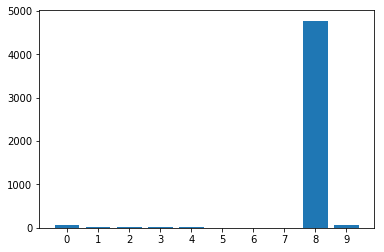

digit activation graph of neuron 21


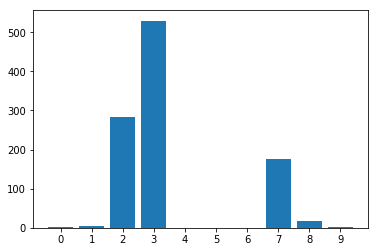

digit activation graph of neuron 22


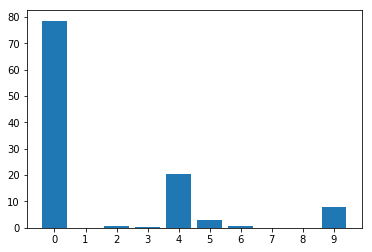

digit activation graph of neuron 23


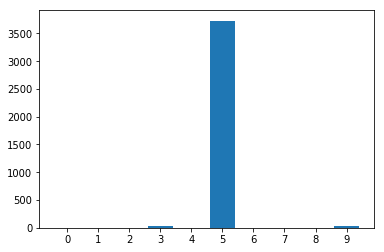

digit activation graph of neuron 24


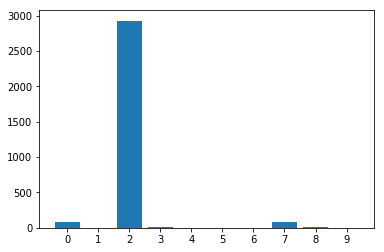

In [40]:
def get_activating_digit(dim_number, test_loader):
    d = defaultdict(lambda : 0)
    for inputs, outputs in test_loader:
        predictions, encoded = classifier(inputs)
        for output, rep in zip(outputs, encoded):
            d[output.item()] += rep.detach().numpy()[dim_number]
    d = sorted(d.items())        
    x = [ e[0] for e in d ]
    y = [ e[1] for e in d ]
    plt.bar(x, y)
    plt.xticks(range(0,10), range(0,10))
    plt.show()

for i in range(25):
    print("digit activation graph of neuron " + str(i))
    get_activating_digit(i, test_loader)
        
        
    


If there were to learn useful representations, there should be similarities for bargraphs between 3 and 8. 

There should be similarities in bargraph that represent the fundamental geometrical differences between digits. 
1 and 7 should have a similar bargraph. I do not see those. 
I see no clear/distinct patterns that would help us do visual question answering or other image understanding tasks. To verify this, we will learn what these neurons are trying to match using optimization 

### Step 3.5 - Draw most confident image for a given neuron

Idea is very similar to the generate most confident image except we try to increase the value of a given neuron instead of probability score


0 -0.2370496392250061 tensor(0.2370, requires_grad=True)
2000 -2743.064208984375 tensor(2743.0642, requires_grad=True)
4000 -5533.80712890625 tensor(5533.8071, requires_grad=True)
6000 -8324.9951171875 tensor(8324.9951, requires_grad=True)
8000 -11119.8994140625 tensor(11119.8994, requires_grad=True)


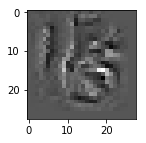

neuron 0 



0 -0.003909453749656677 tensor(0.0039, requires_grad=True)
2000 -18.761798858642578 tensor(18.7618, requires_grad=True)
4000 -40.26007843017578 tensor(40.2601, requires_grad=True)
6000 -61.826385498046875 tensor(61.8264, requires_grad=True)
8000 -83.4577407836914 tensor(83.4577, requires_grad=True)


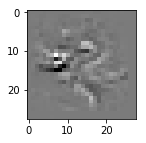

neuron 1 



0 -0.0 tensor(0., requires_grad=True)
2000 -0.0 tensor(0., requires_grad=True)
4000 -0.0 tensor(0., requires_grad=True)
6000 -0.0 tensor(0., requires_grad=True)
8000 -0.0 tensor(0., requires_grad=True)


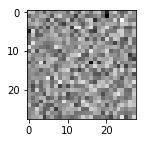

neuron 2 



0 -0.05674046277999878 tensor(0.0567, requires_grad=True)
2000 -2327.462158203125 tensor(2327.4622, requires_grad=True)
4000 -4677.40380859375 tensor(4677.4038, requires_grad=True)
6000 -7028.0908203125 tensor(7028.0908, requires_grad=True)
8000 -9379.001953125 tensor(9379.0020, requires_grad=True)


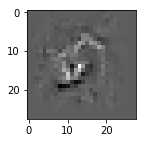

neuron 3 



0 -0.0 tensor(0., requires_grad=True)
2000 -0.0 tensor(0., requires_grad=True)
4000 -0.0 tensor(0., requires_grad=True)
6000 -0.0 tensor(0., requires_grad=True)
8000 -0.0 tensor(0., requires_grad=True)


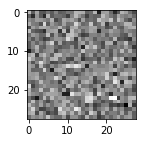

neuron 4 



0 -0.0 tensor(0., requires_grad=True)
2000 -0.0 tensor(0., requires_grad=True)
4000 -0.0 tensor(0., requires_grad=True)
6000 -0.0 tensor(0., requires_grad=True)
8000 -0.0 tensor(0., requires_grad=True)


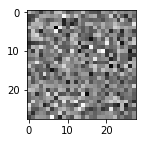

neuron 5 



0 -0.31505125761032104 tensor(0.3151, requires_grad=True)
2000 -1966.074951171875 tensor(1966.0750, requires_grad=True)
4000 -3967.398193359375 tensor(3967.3982, requires_grad=True)
6000 -6047.6923828125 tensor(6047.6924, requires_grad=True)
8000 -8156.578125 tensor(8156.5781, requires_grad=True)


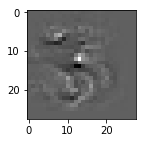

neuron 6 



0 -0.1678003966808319 tensor(0.1678, requires_grad=True)
2000 -310.5799255371094 tensor(310.5799, requires_grad=True)
4000 -638.3021850585938 tensor(638.3022, requires_grad=True)
6000 -970.9782104492188 tensor(970.9782, requires_grad=True)
8000 -1306.04150390625 tensor(1306.0415, requires_grad=True)


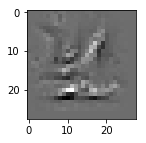

neuron 7 



0 -0.0 tensor(0., requires_grad=True)
2000 -0.0 tensor(0., requires_grad=True)
4000 -0.0 tensor(0., requires_grad=True)
6000 -0.0 tensor(0., requires_grad=True)
8000 -0.0 tensor(0., requires_grad=True)


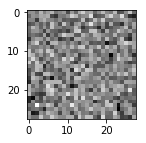

neuron 8 



0 -0.0 tensor(0., requires_grad=True)
2000 -0.0 tensor(0., requires_grad=True)
4000 -0.0 tensor(0., requires_grad=True)
6000 -0.0 tensor(0., requires_grad=True)
8000 -0.0 tensor(0., requires_grad=True)


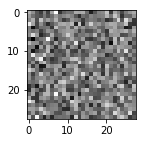

neuron 9 



0 -0.3747173845767975 tensor(0.3747, requires_grad=True)
2000 -403.3302001953125 tensor(403.3302, requires_grad=True)
4000 -821.0404663085938 tensor(821.0405, requires_grad=True)
6000 -1245.7874755859375 tensor(1245.7875, requires_grad=True)
8000 -1671.0321044921875 tensor(1671.0321, requires_grad=True)


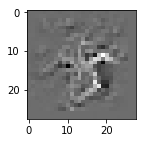

neuron 10 



0 -0.09278127551078796 tensor(0.0928, requires_grad=True)
2000 -72.92626190185547 tensor(72.9263, requires_grad=True)
4000 -148.4148406982422 tensor(148.4148, requires_grad=True)
6000 -224.8240509033203 tensor(224.8241, requires_grad=True)
8000 -301.8005676269531 tensor(301.8006, requires_grad=True)


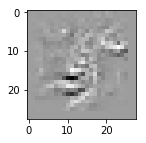

neuron 11 



0 -0.0 tensor(0., requires_grad=True)
2000 -0.0 tensor(0., requires_grad=True)
4000 -0.0 tensor(0., requires_grad=True)
6000 -0.0 tensor(0., requires_grad=True)
8000 -0.0 tensor(0., requires_grad=True)


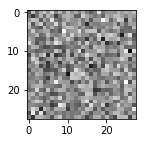

neuron 12 



0 -0.0 tensor(0., requires_grad=True)
2000 -0.0 tensor(0., requires_grad=True)
4000 -0.0 tensor(0., requires_grad=True)
6000 -0.0 tensor(0., requires_grad=True)
8000 -0.0 tensor(0., requires_grad=True)


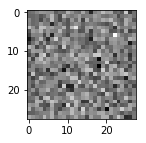

neuron 13 



0 -0.07276281714439392 tensor(0.0728, requires_grad=True)
2000 -837.8698120117188 tensor(837.8698, requires_grad=True)
4000 -1693.5072021484375 tensor(1693.5072, requires_grad=True)
6000 -2549.60693359375 tensor(2549.6069, requires_grad=True)
8000 -3406.0419921875 tensor(3406.0420, requires_grad=True)


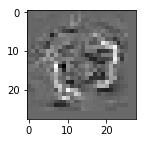

neuron 14 



0 -0.0 tensor(0., requires_grad=True)
2000 -0.0 tensor(0., requires_grad=True)
4000 -0.0 tensor(0., requires_grad=True)
6000 -0.0 tensor(0., requires_grad=True)
8000 -0.0 tensor(0., requires_grad=True)


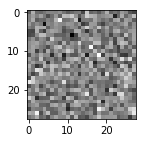

neuron 15 



0 -0.12857051193714142 tensor(0.1286, requires_grad=True)
2000 -2375.6357421875 tensor(2375.6357, requires_grad=True)
4000 -4892.80126953125 tensor(4892.8013, requires_grad=True)
6000 -7417.2236328125 tensor(7417.2236, requires_grad=True)
8000 -9964.916015625 tensor(9964.9160, requires_grad=True)


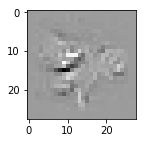

neuron 16 



0 -0.20929846167564392 tensor(0.2093, requires_grad=True)
2000 -808.5574951171875 tensor(808.5575, requires_grad=True)
4000 -1630.7874755859375 tensor(1630.7875, requires_grad=True)
6000 -2453.140625 tensor(2453.1406, requires_grad=True)
8000 -3275.68505859375 tensor(3275.6851, requires_grad=True)


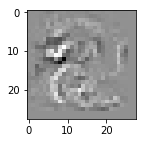

neuron 17 



0 -0.16720856726169586 tensor(0.1672, requires_grad=True)
2000 -459.9018859863281 tensor(459.9019, requires_grad=True)
4000 -928.51171875 tensor(928.5117, requires_grad=True)
6000 -1398.03466796875 tensor(1398.0347, requires_grad=True)
8000 -1867.587646484375 tensor(1867.5876, requires_grad=True)


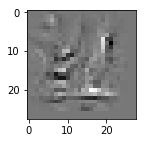

neuron 18 



0 -0.0 tensor(0., requires_grad=True)
2000 -0.0 tensor(0., requires_grad=True)
4000 -0.0 tensor(0., requires_grad=True)
6000 -0.0 tensor(0., requires_grad=True)
8000 -0.0 tensor(0., requires_grad=True)


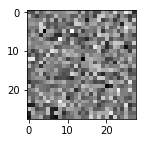

neuron 19 



0 -0.3984023332595825 tensor(0.3984, requires_grad=True)
2000 -792.3058471679688 tensor(792.3058, requires_grad=True)
4000 -1665.6221923828125 tensor(1665.6222, requires_grad=True)
6000 -2539.99658203125 tensor(2539.9966, requires_grad=True)
8000 -3419.148681640625 tensor(3419.1487, requires_grad=True)


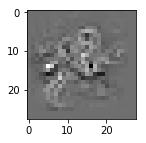

neuron 20 



0 -0.2987949252128601 tensor(0.2988, requires_grad=True)
2000 -236.92041015625 tensor(236.9204, requires_grad=True)
4000 -480.9941711425781 tensor(480.9942, requires_grad=True)
6000 -725.2840576171875 tensor(725.2841, requires_grad=True)
8000 -969.6610107421875 tensor(969.6610, requires_grad=True)


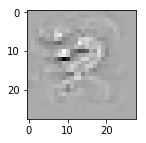

neuron 21 



0 -0.00041725486516952515 tensor(0.0004, requires_grad=True)
2000 -17.4101505279541 tensor(17.4102, requires_grad=True)
4000 -37.374488830566406 tensor(37.3745, requires_grad=True)
6000 -57.40922546386719 tensor(57.4092, requires_grad=True)
8000 -77.47085571289062 tensor(77.4709, requires_grad=True)


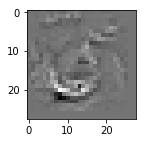

neuron 22 



0 -0.025539934635162354 tensor(0.0255, requires_grad=True)
2000 -1404.652099609375 tensor(1404.6521, requires_grad=True)
4000 -2877.51220703125 tensor(2877.5122, requires_grad=True)
6000 -4361.27099609375 tensor(4361.2710, requires_grad=True)
8000 -5849.4677734375 tensor(5849.4678, requires_grad=True)


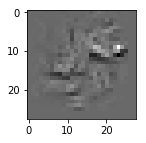

neuron 23 



0 -0.2920200824737549 tensor(0.2920, requires_grad=True)
2000 -560.200439453125 tensor(560.2004, requires_grad=True)
4000 -1167.770751953125 tensor(1167.7708, requires_grad=True)
6000 -1775.14599609375 tensor(1775.1460, requires_grad=True)
8000 -2382.76611328125 tensor(2382.7661, requires_grad=True)


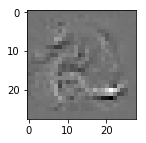

neuron 24 





In [51]:

def generate_most_confident_image_neuron(dim):
    x = torch.randn((1,1,28,28), requires_grad = True)
    lr = 10
    for i in range(10000):
        predictions, encoded = classifier(x)
        loss = -encoded[0][dim]
        loss.backward()
        with torch.no_grad():
            x -= lr * x.grad
            x.grad.zero_()
            if i % 2000 == 0:
                print(i, loss.item(), encoded[0][dim])

    x = x.detach().numpy()
    x = x.reshape((28,28))
    display(x)
    
    return 

for i in range(25):
    generate_most_confident_image_neuron(i)
    print('neuron',i,'\n\n\n')

* Some neurons can never be fired. These correspond best to images with complete noise.
* 0 th neuron is looking for 5/6. 6 th neuron is looking for a clear 3. 
* The neurons are getting activated by the digit themselves and small regions of high gradients. Zoom into any image, you will see a distinct group of white and blak square boxes where gradients are high. These could be the "critical" pixels where any change in pixel value drastically affects the class.
![Critical Pixels ?](critical.png)
* Our sparse vector is not learning finer representation than the given digits themselves. It is not surprising, a sparse representation vector was the first thing that came to my mind. 



### Step 3.5 - Get patch that activate an image the most

original image


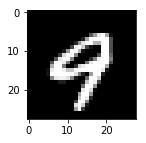

patch that activates neuron 3


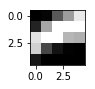

patch that activates neuron 16


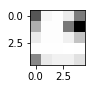

patch that activates neuron 19


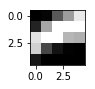

In [76]:
# Find what part of image contributes to probability score by occluding image


def get_most_activating_patch(digit_image, dim, test_loader):
    heat_map = np.zeros((28,28))
    
    digit_image = digit_image.reshape((28,28,1))
    actual_predictions, actual_encoded = classifier(digit_image.reshape((1,28,28,1)))
    max_difference = 0
    best_patch = None

    for i in range(25):
        for j in range(23):
            occluded_image = digit_image.numpy().copy()
            occluded_image[i:i+5,j:j+5] = 0
            occluded_predictions, occluded_encoded = classifier(torch.tensor(occluded_image.reshape((1,28,28,1))))
            difference = 255 * abs(actual_encoded[0][dim].item() - occluded_encoded[0][dim].item())
            if difference >= max_difference:
                best_patch = digit_image[i:i+5,j:j+5]
                max_difference = difference
                
    if max_difference > 500:
        print('patch that activates neuron', dim)
        plt.figure(figsize=(1,1))
        plt.imshow(best_patch.data.reshape((best_patch.shape[0], best_patch.shape[1])), cmap = 'gray')
        plt.show()
        



Patches 3 and 19 are picking up the fact that there is patch with a positive slope. It is also picking up on the edge. So there is some hope.

- Step 3 summary

    * Localization is a natural byproduct of object classification.
    * Most confident images generated by network does have strong structural similarities with target categories, but they do have a lot of high dimensional noise.
    * The representation does pick on some useful things, it picked the positive slopes in the digit 9. digit 9 has 3 distinct areas of positive slope. 
    * The sparse representation that we used did not reveal other super interesting properties. It learned to correspond to the class itself than features of the class. Moving this sparse layer earlier in the network might be helpful.

### Step 3 ends here

* Our representations are nowhere near the amazing cyclops representation we had in mind. 
* Our representations are prone to attacks and are not easily interpretable. 
* Our representations are attributable. (Can correctly point out which region of input that made the network fire)
* We have to go forwards with some hope and some caution. 